In [40]:
from paths import DATASET_IMG, FRONTAL, LATERAL, DATASET_CARS
import os
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
import numpy as np
import imutils
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [41]:
FRONTALIMAGES = [str(FRONTAL / image_name) for image_name 
                        in os.listdir(FRONTAL)]

LATERALIMAGES = [str(LATERAL / image_name) for image_name 
                        in os.listdir(LATERAL)]

In [42]:
def preprocess_image(img_path):
    """Preprocess the image and return required intermediates."""
    # Read the image
    img = cv2.imread(img_path)
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Noise reduction using bilateral filter
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
    # Edge detection using Canny
    edged = cv2.Canny(bfilter, 30, 200)
    return img, gray, edged

def find_license_plate_aspect_ratio(edged):
    """Find and return the contour of the license plate."""
    # Find contours in the edge-detected image
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)

    good_contours = []
    height, width = edged.shape
    # Calculating buffer in terms of pixels
    border_buffer_x = width * 0.2
    border_buffer_y = height * 0.2
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Check if the contour is inside the buffered region
        if (x > border_buffer_x) and (x + w < width - border_buffer_x) and \
           (y > border_buffer_y) and (y + h < height - border_buffer_y):
                aspect_ratio = float(w) / h
                if (1.2 < aspect_ratio < 8):
                    good_contours.append(contour)
                    
    good_contours = sorted(good_contours, key=cv2.contourArea, reverse=True)[:200]
    return None if len(good_contours) == 0 else good_contours


### Method for obtaining things that are not license Plates

In [43]:
def distance_bounding_boxes(box1, box2):
    # Define the coordinates of the two bounding boxes as (x_min, y_min, x_max, y_max)
    (x_min1, y_min1, x_max1, y_max1) = box1
    (x_min2, y_min2, x_max2, y_max2) = box2

    # Calculate the center coordinates of the two bounding boxes
    center1 = ((x_min1 + x_max1) / 2, (y_min1 + y_max1) / 2)
    center2 = ((x_min2 + x_max2) / 2, (y_min2 + y_max2) / 2)

    # Define a distance threshold (you can adjust this as needed)
    distance_threshold = 10  # Adjust this threshold as needed

    # Calculate the Euclidean distance between the centers of the two bounding boxes
    distance = math.sqrt((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)

    # Check if the distance is less than the threshold to determine if they are near
    if distance < distance_threshold:
       return True
    else:
        return False
    
# Image for the cordiantes
def bounding_box_licensplate(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bndbox = root.find('.//bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    return ymin, xmin, ymax, xmax

def obtain_negative_samples(xml_file, img, gray, locations):
    box1 = bounding_box_licensplate(xml_file)
    negativsamples = []
    for location in (locations):
        # A mask with the shape of the image that contains all 0
        mask = np.zeros(gray.shape, np.uint8)
        # In the mask put 1 in the locations specifed by location 
        cv2.drawContours(mask, [location], 0, 255, -1)
        # Then in the original image mark the zone of interest with the mask
        cv2.bitwise_and(img, img, mask=mask)
        # Obatin the cordinates where the mask has 1 which is the locations that we are insterested
        (x, y) = np.where(mask==255)
        # Obtain the hight and the whith of the location
        (xmin, ymin) = (np.min(x), np.min(y))
        (xmax, ymax) = (np.max(x), np.max(y))
        box2 = (xmin, ymin, xmax, ymax)
        cropped_image = gray[xmin:xmax+1, ymin:ymax+1]
        # We stored those locations that are far from the licensplate
        if not distance_bounding_boxes(box1, box2):
            negativsamples.append(cropped_image)
    return negativsamples

# Main method to process the image and visualize the results
def negative_samples(xml_path, img_path):
    img, gray, edged = preprocess_image(img_path)
    locations = find_license_plate_aspect_ratio(edged)
    if locations is None:
        print("Sorry, license plate not detected.")
        return
    cropped_image_noise = obtain_negative_samples(xml_path, img, gray, locations)
    return cropped_image_noise
    #return img, locations # Returns the contours that SVM needs to classify

### Method for obtaining the licensplates

In [64]:
def licensplate(xml_path, image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    # Load XML from file
    tree = ET.parse(xml_path)
    root = tree.getroot()
    # Extract bounding box
    bndbox = root.find('.//bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    licens_gray = img_gray[ymin:ymax, xmin:xmax]
    shape = licens_gray.shape
    if not 0 in shape:
        return licens_gray
    return None

### Constructing the Dataset

In [65]:
def read_files():
    xml_files, png_files = [], []

    sorted_xml_dataset1 = sorted(os.listdir(DATASET_IMG / 'annotations'), key = lambda x: int(x[1:-4]))
    sorted_png_dataset1 = sorted(os.listdir(DATASET_IMG / 'images'), key = lambda x: int(x[1:-5]))

    sorted_xml_dataset2 = sorted(os.listdir(DATASET_CARS / 'annotations'), key = lambda x: int(x[4:-4]))
    sorted_png_dataset2 = sorted(os.listdir(DATASET_CARS / 'images'), key = lambda x: int(x[4:-4]))

    for png, xml in zip(sorted_png_dataset1, sorted_xml_dataset1):
        xml_files.append(str(DATASET_IMG / 'annotations'/ xml))
        png_files.append(str(DATASET_IMG / 'images' / png))

    for png, xml in zip(sorted_png_dataset2, sorted_xml_dataset2):
        xml_files.append(str(DATASET_CARS / 'annotations' / xml))
        png_files.append(str(DATASET_CARS / 'images' / png))

    return xml_files, png_files

def obtain_sift_features(gray_licensplates):
    sift = cv2.SIFT_create()

    #For each image compute their sift features
    sift_features =  list(map(lambda gray_image: sift.detectAndCompute(gray_image, None)[1], gray_licensplates))
    
    # Filter the images that have no sift features. Compress for each image all the sift features found in one row of shape (1, 128)
    sift_features = filter(lambda image_path: image_path is not None, sift_features)
    sift_features = list(map(lambda features: features.sum(0), sift_features))

    sift_features = np.vstack(sift_features)


    return sift_features

In [66]:
def constuct_samples():
    xml_files, png_files = read_files()

    negative_samples_list = []
    licensplates = []

    # Iterate trought the images 
    for xml_path, img_path in zip(xml_files, png_files):
        # Obtain the licensplate
        licens_gray = licensplate(xml_path, img_path)
        if licens_gray is None:
            continue
        licensplates.append(licens_gray)

    for idx, (xml_path, img_path) in enumerate(zip(xml_files, png_files)):
        if idx == 8:
            break
        # For each image obtain the regions that are not the licensplates.
        neg_samples = negative_samples(xml_path, img_path)
        negative_samples_list.extend(neg_samples)
    
    return licensplates, negative_samples_list

In [67]:
# Licensplates and non-licensplates
licensplates, negative_samples_list = constuct_samples()

# For each of the licensplates and the things that are not licensplates obtain their sift-features
features_licensplate, negative_samples = obtain_sift_features(licensplates), obtain_sift_features(negative_samples_list)

# Stack all the features in a single matrix called X. The matrix Y will stored the ground truth
X = np.vstack((features_licensplate, negative_samples))

# 1 for Licensplate
ground_truth_licensplates = np.ones((len(features_licensplate), 1))
# 0 for not licensplate
ground_truht_negative_samples = np.zeros((len(negative_samples), 1))

Y = np.vstack((ground_truth_licensplates, ground_truht_negative_samples))

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
y_train, y_test = y_train.ravel(), y_test.ravel()

### Training

In [73]:
clf_logistic = LogisticRegression(random_state=0, max_iter=20000)
clf_logistic.fit(X_train, y_train)

clf_svm      = svm.SVC(kernel='rbf', C=1.0)
clf_svm.fit(X_train, y_train)

SVC()

### Evaluation

In [74]:
y_pred_logistic = clf_logistic.predict(X_test)
y_pred_svm      = clf_svm.predict(X_test)

accuracy_logistic = accuracy_score(y_pred_logistic, y_test)
accuracy_svm      = accuracy_score(y_pred_svm, y_test)

print("Accuracy score for logistic regression:\t{}".format(accuracy_logistic))
print("Accuracy score for SVM:\t{}".format(accuracy_svm))

Accuracy score for logistic regression:	0.8453237410071942
Accuracy score for SVM:	0.8093525179856115


### Qualitative results

In [75]:
def extract_patch_from_image(img, gray, locations):
    cropped_images = []

    for location in (locations):
        mask = np.zeros(gray.shape, np.uint8)
        cv2.drawContours(mask, [location], 0, 255, -1)
        cv2.bitwise_and(img, img, mask=mask)
        (x, y) = np.where(mask==255)
        (x1, y1) = (np.min(x), np.min(y))
        (x2, y2) = (np.max(x), np.max(y))
        #cropped_image = gray[x1:x2+1, y1:y2+1]
        cropped_image = img[x1:x2+1, y1:y2+1]
        cropped_images.append(cropped_image)
    return cropped_images

# Main method to process the image and visualize the results
def method_3(img_path):
    img, gray, edged = preprocess_image(img_path)
    locations = find_license_plate_aspect_ratio(edged)
    if locations is None:
        print("Sorry, license plate not detected.")
        return
    cropped_images = extract_patch_from_image(img, gray, locations)
    return cropped_images
    #return img, locations # Returns the contours that SVM needs to classify

#### Test images

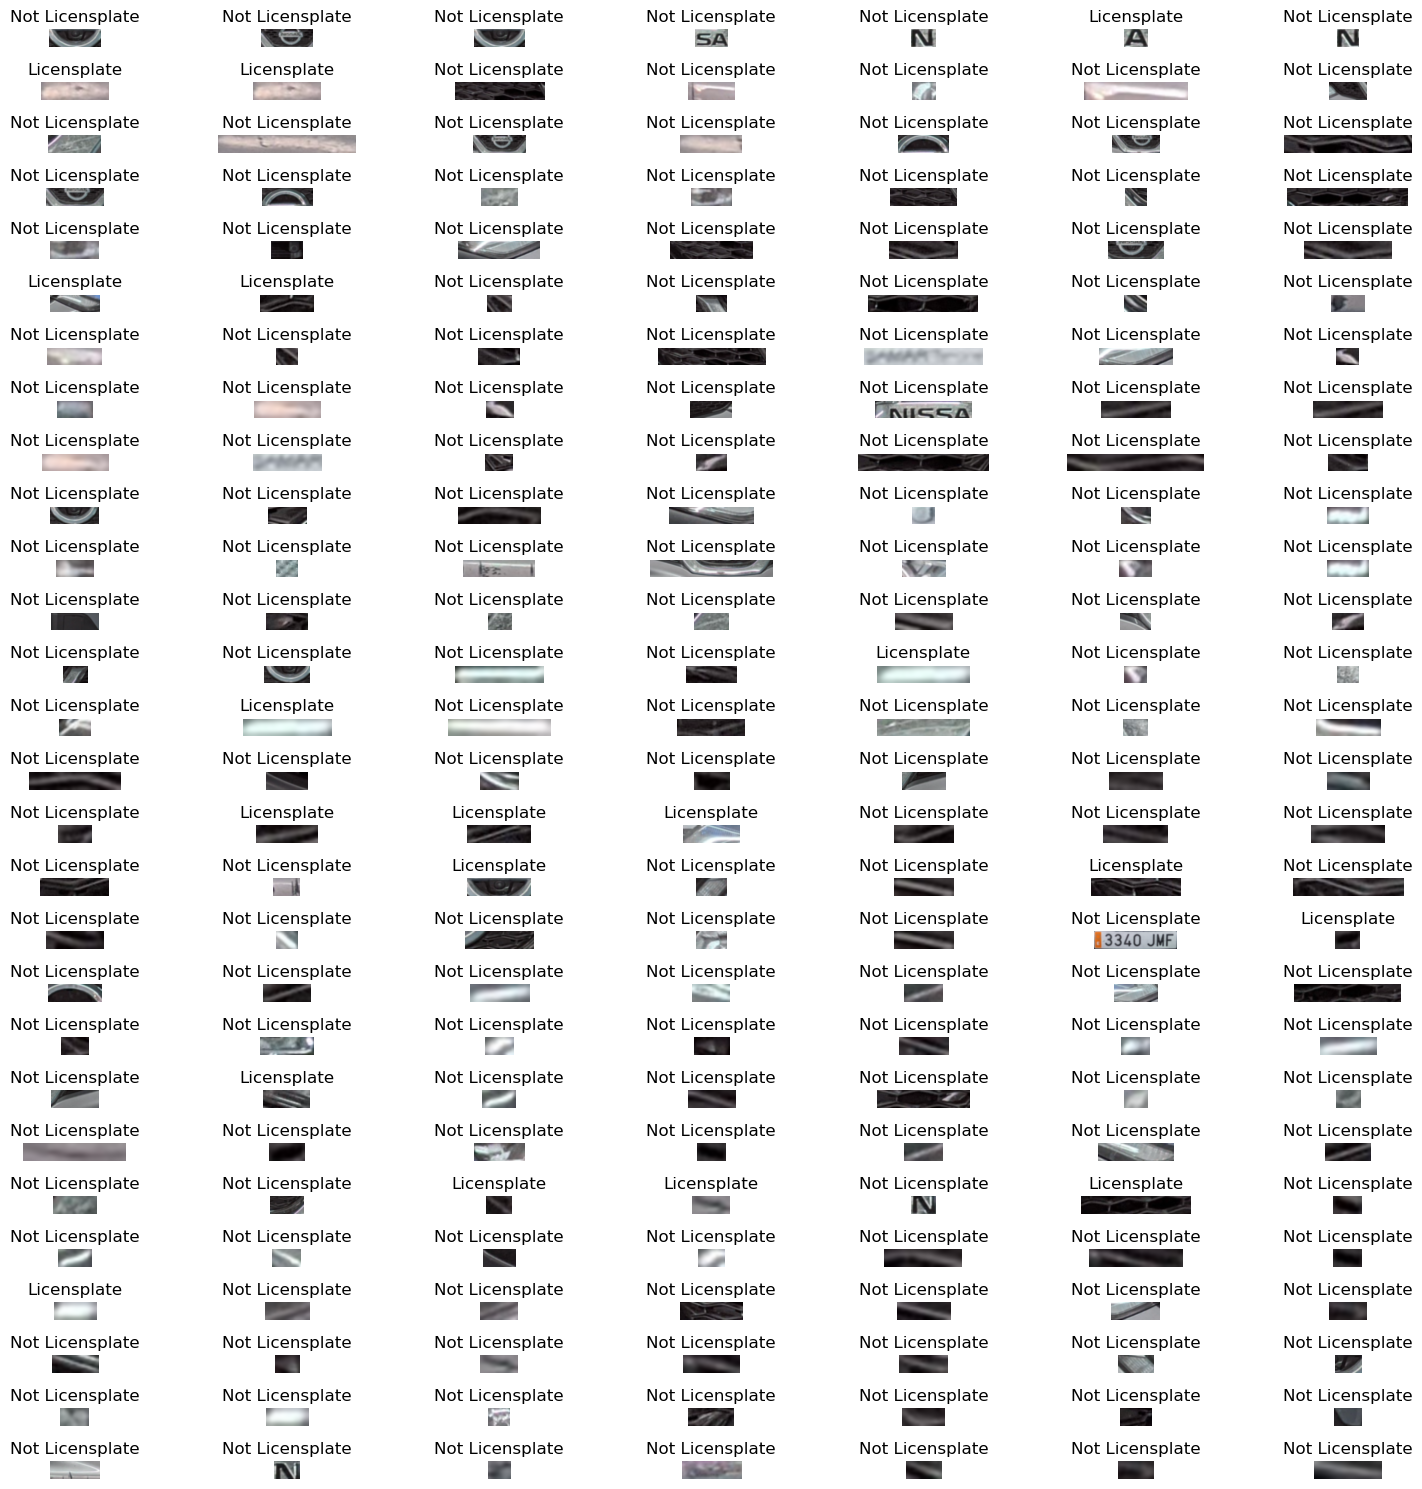

In [146]:
cropped_images = method_3(FRONTALIMAGES[4]) # Well detected frontal: 0 1 2 3 6 9 11 13 14
                                            # Well detected lateral: 0 1 4 5 11
features = obtain_sift_features(cropped_images)

result = clf_logistic.predict(features)
predict_license = np.where(1 == result)[0].tolist()
precit_no_license = np.where(0 == result)[0].tolist()

# Set the figure size to make subplots larger
fig = plt.figure(figsize=(15, 15))

# Create a 10x10 grid of subplots
for i, image in enumerate(cropped_images):
    if (i == (len(cropped_images) // 7) * 7):
        break
    plt.subplot(len(cropped_images) // 7, 7, (i + 1))
    
    if i in predict_license:
        title = "Licensplate"
    else:
        title = "Not Licensplate"

    # Adjust the aspect ratio to prevent stretching
    plt.gca().set_aspect('equal', adjustable='box')
    
    # You can adjust the size of the image by setting the interpolation
    plt.imshow(image, cmap='gray', interpolation='bicubic')
    
    plt.title(title)
    plt.axis('off')  # Optional: Hide axis labels

plt.tight_layout()
plt.show()

In [115]:
#pipeline = keras_ocr.pipeline.Pipeline()
import easyocr
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [99]:
def plot_predicted_license(predict_license):
    fig = plt.figure(figsize=(12, 12))
    # Create a 10x10 grid of subplots
    for i, pred in enumerate(predict_license, start=1):
        plt.subplot(len(predict_license), 4, i)

        # Adjust the aspect ratio to prevent stretching
        plt.gca().set_aspect('equal', adjustable='box')

        # You can adjust the size of the image by setting the interpolation
        plt.imshow(pred, cmap='gray', interpolation='bicubic')

        plt.axis('off')  # Optional: Hide axis labels

    plt.tight_layout()
    plt.show()

In [139]:
def predict_text(image_path):
    plt.imshow(cv2.imread(image_path))
    plt.show()
    cropped_images = method_3(image_path)
    features = obtain_sift_features(cropped_images)

    result = clf_logistic.predict(features)
    predict_license = np.where(1 == result)[0].tolist()

    predicted_immages = [cropped_images[idx] for idx in predict_license]
    #plot_predicted_license(predicted_immages)
    license_texts = []
    for img in predicted_immages:
        results = reader.readtext(img, allowlist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
        texts = [result[1] for result in results]
        if len(texts) == 0:
            continue
        license_texts.append(' '.join(texts))

    return license_texts

[([[50, 200], [104, 200], [104, 260], [50, 260]], 'E', 0.9940410483711872),
 ([[175, 31], [1223, 31], [1223, 288], [175, 288]],
  '1062FNT',
  0.9454094320756896)]

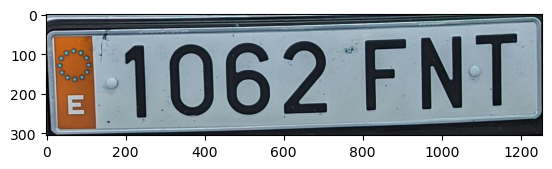

In [121]:
plt.imshow(cropped_images[0])
reader.readtext(cropped_images[0], allowlist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')

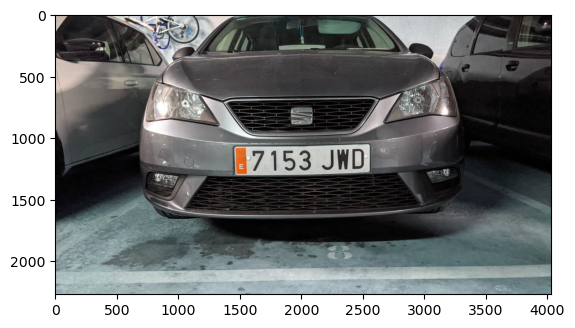

Predicted License Plate: ['E 7153JHD', 'E 7153JHD']


In [149]:
idx = 11
text = predict_text(FRONTALIMAGES[idx])
print("Predicted License Plate:", text)